In [1]:
%matplotlib inline

In [2]:
pwd

'/Users/jeremymobley/Desktop/cbb_modeling/Python'

In [3]:
from helper_functions import *

In [4]:
cd /Users/jeremymobley/Desktop/cbb_modeling/data/2018/

/Users/jeremymobley/Desktop/cbb_modeling/data/2018


In [5]:
import scipy
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn import linear_model
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn import feature_selection
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

#### Load Data

In [6]:
teams = read_in_file_to_df("Teams")
tourney_compact_results = read_in_file_to_df("NCAATourneyCompactResults")
tourney_detailed_results = read_in_file_to_df("NCAATourneyDetailedResults")
reg_season_detailed_results = read_in_file_to_df("RegularSeasonDetailedResults")
reg_season_compact_results = read_in_file_to_df("RegularSeasonCompactResults")
sample_sub1 = read_in_file_to_df("SampleSubmissionStage1")
sample_sub2 = read_in_file_to_df("SampleSubmissionStage2")
seasons = read_in_file_to_df("Seasons")

Teams (364, 4)
NCAATourneyCompactResults (2117, 8)
NCAATourneyDetailedResults (981, 34)
RegularSeasonDetailedResults (82041, 34)
RegularSeasonCompactResults (156089, 8)
SampleSubmissionStage1 (9112, 2)
SampleSubmissionStage2 (2278, 2)
Seasons (34, 6)


#### Combine regular season and tourney detailed results

In [7]:
all_detailed_results = pd.concat([reg_season_detailed_results, tourney_detailed_results])
print(all_detailed_results.shape)

(83022, 34)


### Calculate Advanced Metrics

#### Add in possession features

In [8]:
all_detailed_results = create_poss_fields(all_detailed_results)
all_detailed_results = create_ppp_fields(all_detailed_results)

#### Add advanced metrics
Takes a few seconds...

In [9]:
all_detailed_results = add_advanced_metrics(all_detailed_results)

#### Add in date from DayNum

In [10]:
all_detailed_results = add_in_date(all_detailed_results, seasons)
print(all_detailed_results.shape)

(83022, 62)


#### Add in team names

In [11]:
all_detailed_results = add_in_team_names(all_detailed_results, teams)
print(all_detailed_results.shape)

(83022, 64)


In [12]:
# Add in score_diff field
all_detailed_results['score_diff'] = all_detailed_results['WScore'] - all_detailed_results['LScore']
print(all_detailed_results.shape)

(83022, 65)


## Create train data set

Train data set structure:  
* Result field is binary 0/1 representing if Team1 beats Team2
* Every game is represented by 2 different records

In [13]:
train = create_master_train(all_detailed_results)
print(train.shape)

(166044, 66)


In [14]:
# Create location variables
train['t1_Loc_H'] = [1 if loc=="H" else 0 for loc in train['t1_Loc']]
train['t1_Loc_N'] = [1 if loc=="N" else 0 for loc in train['t1_Loc']]

#### Add in Massey Ordinals

In [15]:
# Read in massey_ordinals file
massey_ordinals = read_in_file_to_df("MasseyOrdinals_thruSeason2018_Day128")
massey_ordinals_18 = read_in_file_to_df("MasseyOrdinals_2018_133_only_43Systems")
massey_ordinals.columns = ['Season', 'DayNum', 'SystemName', 'TeamID', 'OrdinalRank']
massey_ordinals_18.columns = ['Season', 'DayNum', 'SystemName', 'TeamID', 'OrdinalRank']
massey_ordinals = pd.concat([massey_ordinals, massey_ordinals_18])
print(massey_ordinals.shape)

MasseyOrdinals_thruSeason2018_Day128 (3470328, 5)
MasseyOrdinals_2018_133_only_43Systems (13854, 5)
(3484182, 5)


In [16]:
massey_rank_systems = ["WLK", "DOK", "POM", "MOR", "SAG", "WIL", "PGH", "NOL", "KPK", "MAS"]

In [17]:
for rnk_sys in massey_rank_systems:
    train = add_in_massey_ordinal_field(train, rnk_sys, massey_ordinals)

##### Look at Massey Ordinal data

In [374]:
# Look at most populated ranking systems
massey_ordinals[(massey_ordinals['DayNum']>50) & (massey_ordinals['Season']>2010)]['SystemName'].value_counts().head(10)

WLK    31043
DOK    31043
POM    31043
MOR    31043
SAG    31043
WIL    31042
PGH    31030
NOL    31011
KPK    30695
MAS    30695
Name: SystemName, dtype: int64

## Look at all train records

In [20]:
HTML(train[(train['Season']==2018) & (train['t1_TeamID']==1207)].sort_values('DayNum').head().to_html())

,DayNum,NumOT,Result,Season,TotPoss,game_date,score_diff,t1_Ast,t1_AstR,t1_Blk,t1_DR,t1_DRP,t1_DefRtg,t1_FGA,t1_FGA3,t1_FGM,t1_FGM3,t1_FTA,t1_FTAR,t1_FTM,t1_Loc,t1_NetRtg,t1_OR,t1_ORP,t1_OffRtg,t1_PF,t1_PPP,t1_Poss,t1_RP,t1_Score,t1_Stl,t1_TO,t1_TOR,t1_TSP,t1_TeamID,t1_TeamName,t1_eFGP,t2_Ast,t2_AstR,t2_Blk,t2_DR,t2_DRP,t2_DefRtg,t2_FGA,t2_FGA3,t2_FGM,t2_FGM3,t2_FTA,t2_FTAR,t2_FTM,t2_NetRtg,t2_OR,t2_ORP,t2_OffRtg,t2_PF,t2_PPP,t2_Poss,t2_RP,t2_Score,t2_Stl,t2_TO,t2_TOR,t2_TSP,t2_TeamID,t2_TeamName,t2_eFGP,t1_Loc_H,t1_Loc_N,t1_WLK_rnk,t2_WLK_rnk,t1_WLK_rnk_diff,t1_DOK_rnk,t2_DOK_rnk,t1_DOK_rnk_diff,t1_POM_rnk,t2_POM_rnk,t1_POM_rnk_diff,t1_MOR_rnk,t2_MOR_rnk,t1_MOR_rnk_diff,t1_SAG_rnk,t2_SAG_rnk,t1_SAG_rnk_diff,t1_WIL_rnk,t2_WIL_rnk,t1_WIL_rnk_diff,t1_PGH_rnk,t2_PGH_rnk,t1_PGH_rnk_diff,t1_NOL_rnk,t2_NOL_rnk,t1_NOL_rnk_diff,t1_KPK_rnk,t2_KPK_rnk,t1_KPK_rnk_diff,t1_MAS_rnk,t2_MAS_rnk,t1_MAS_rnk_diff
6247,13,0,1.0,2018,144.050,2017-11-12,16.0,18,17.992803,7,26,0.634146,39.569594,57,26,26,10,16,0.280702,11,H,0.0,11,0.333333,50.676848,20,1.013537,71.600,0.500000,73,9,18,11.261261,56.995628,1207,Georgetown,0.543860,11,11.261261,1,22,0.666667,50.676848,55,15,18,7,22,0.400000,14,-11.107254,15,0.365854,39.569594,19,0.791392,72.450,0.445946,57,4,22,11.261261,44.063080,1239,Jacksonville,0.390909,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8906,16,0,1.0,2018,152.200,2017-11-15,34.0,25,21.626298,4,37,0.840909,44.678055,68,22,39,11,15,0.220588,13,H,0.0,14,0.466667,67.017083,17,1.340342,77.125,0.689189,102,5,16,14.662757,68.364611,1207,Georgetown,0.654412,14,14.662757,2,16,0.533333,67.017083,65,33,25,8,17,0.261538,10,-22.339028,7,0.159091,44.678055,17,0.893561,75.075,0.405405,68,7,9,14.662757,46.909492,1291,Mt St Mary's,0.446154,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12654,19,0,1.0,2018,139.050,2017-11-18,26.0,24,23.319083,5,37,0.822222,40.992449,58,19,30,9,18,0.310345,14,H,0.0,11,0.379310,59.690759,17,1.193815,68.550,0.648649,83,2,13,13.363029,62.955097,1207,Georgetown,0.594828,12,13.363029,3,18,0.620690,59.690759,62,19,20,3,20,0.322581,14,-18.698310,8,0.177778,40.992449,15,0.819849,70.500,0.391892,57,6,7,13.363029,40.254237,1271,MD E Shore,0.346774,1,0,NaN,NaN,NaN,68.0,341.0,-273.0,80.0,328.0,-248.0,56.0,310.0,-254.0,76.0,338.0,-262.0,NaN,NaN,NaN,84.0,309.0,-225.0,NaN,NaN,NaN,NaN,NaN,NaN,63.0,328.0,-265.0
24153,26,0,1.0,2018,136.475,2017-11-25,6.0,15,16.404199,2,26,0.722222,55.687855,47,18,25,10,26,0.553191,22,A,0.0,9,0.346154,60.084265,15,1.201685,68.350,0.564516,82,5,18,13.392857,70.157426,1207,Georgetown,0.638298,12,13.392857,3,17,0.653846,60.084265,63,27,29,7,15,0.238095,11,-4.396410,10,0.277778,55.687855,18,1.113757,68.125,0.419355,76,9,8,13.392857,54.597701,1350,Richmond,0.515873,0,0,NaN,NaN,NaN,54.0,202.0,-148.0,74.0,170.0,-96.0,48.0,114.0,-66.0,63.0,186.0,-123.0,NaN,NaN,NaN,85.0,156.0,-71.0,NaN,NaN,NaN,NaN,NaN,NaN,59.0,177.0,-118.0
28306,29,0,1.0,2018,135.525,2017-11-28,21.0,13,14.167393,4,23,0.621622,40.582918,54,18,25,4,29,0.537037,22,H,0.0,13,0.382353,56.078214,15,1.121564,66.775,0.507042,76,8,12,8.849558,56.920312,1207,Georgetown,0.500000,8,8.849558,5,21,0.617647,56.078214,60,23,22,4,10,0.166667,7,-15.495296,14,0.378378,40.582918,20,0.811658,68.750,0.478873,55,5,18,8.849558,42.701863,1263,Maine,0.400000,1,0,NaN,NaN,NaN,54.0,340.0,-286.0,74.0,337.0,-263.0,48.0,326.0,-278.0,63.0,341.0,-278.0,NaN,NaN,NaN,85.0,344.0,-259.0,NaN,NaN,NaN,NaN,NaN,NaN,59.0,341.0,-282.0


---

## DEV

#### Add rolling features - working..

In [ ]:
def create_rolling_avg_feature(df, field_to_agg, num_games=5):
    df = df.sort_values(['t1_TeamID', 'Season','DayNum']).reset_index()
    col_name = field_to_agg + "_rolling_avg_" + str(num_games) + "gm"
    df[col_name] = df.groupby(['Season', 't1_TeamID'])[[field_to_agg]].shift(1) \
        .rolling(window=num_games, min_periods=num_games).mean()
    return df

In [92]:
train = train.sort_values(['t1_TeamID', 'Season','DayNum']).reset_index()

ValueError: cannot insert level_0, already exists

In [68]:
train['t1_offPPP_rolling_avg_5gm'] = train.groupby(['Season', 't1_TeamID'])[['t1_PPP']].shift(1) \
        .rolling(window=5, min_periods=5).mean()

In [67]:
train['t1_defPPP_rolling_avg_5gm'] = train.groupby(['Season', 't1_TeamID'])[['t2_PPP']].shift(1) \
        .rolling(window=5, min_periods=5).mean()

In [95]:
train['t1_offPPP_ssn_avg'] = train.groupby(['Season', 't1_TeamID'])[['t1_PPP']].shift(1) \
        .rolling(window=20, min_periods=15).mean()

In [14]:
train = create_rolling_avg_feature(train, "t1_PPP", num_games=5)
train = create_rolling_avg_feature(train, "t2_PPP", num_games=5)

In [70]:
num_games = 5
#train = train.sort_values(['t1_TeamID', 'Season','DayNum']).reset_index()
agg_funcs = {'t1_PPP':['mean', 'max'], 't2_PPP':['mean']}
train_metrics_agg = train.groupby(['Season', 't1_TeamID']).shift(1) \
    .rolling(window=num_games, min_periods=num_games).agg(agg_funcs)

In [74]:
train_metrics_agg.columns = ['t1_PPP_mean', 't1_PPP_max', 't2_PPP_mean']
train_metrics_agg.shape

In [75]:
train_metrics_agg.head(10)

,t1_PPP_mean,t1_PPP_max,t2_PPP_mean
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,0.806336,1.004315,1.218981
6,0.804361,1.004315,1.250998
7,0.807975,1.004315,1.253397
8,0.879251,1.043478,1.268299
9,0.947804,1.043478,1.179179


### Loop through train to create features

##### Dev process for one season

In [120]:
start_time = time.time()

# create 2017 df for dev
train_17 = train[train['Season']==2017].copy().reset_index(drop=True).sort_values(['DayNum'])
train_17['t1_off_ssn_avg_PPP'] = 0

# create team_metrics_dict to track ongoing metrics
team_metrics_dict = {tm_id: {'gp': 0, 't1_off_ssn_avg_PPP': 0} for tm_id in train['t1_TeamID'].unique()}

# loop through each record in train_17
for i, row in enumerate(train_17[['t1_TeamID', 't1_PPP']].itertuples(index=False), 1):

    if i % 1000 == 0 :
        print(i)

    t1 = row[0]
    t1_game_PPP = row[1]
    t1_gp = team_metrics_dict.get(t1).get('gp')
    t1_ssn_avg_PPP = team_metrics_dict.get(t1).get('t1_off_ssn_avg_PPP')
    
    # update train_17
    train_17.loc[i, 't1_off_ssn_avg_PPP'] = t1_ssn_avg_PPP
    
    # update team_metrics_dict
    team_metrics_dict[t1]['t1_off_ssn_avg_PPP'] = ((t1_ssn_avg_PPP * t1_gp) + t1_game_PPP)/ (t1_gp + 1.0)
    team_metrics_dict[t1]['gp'] += 1

# write out final season_totals for 2018 to use for test


print("Processing took " + str(int(round(time.time() - start_time))) + " seconds")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Processing took 4 seconds


In [118]:
print(train_17[train_17['t1_off_ssn_avg_PPP']==0].shape)
print(train_17[train_17['t1_off_ssn_avg_PPP']>0].shape)
print(train_17['t1_off_ssn_avg_PPP'].mean())

(351, 99)
(10573, 99)
0.9955991253743911


#### Loop through all seasons

In [136]:
start_time = time.time()
all_seasons_train = pd.DataFrame()
for season_yr in train['Season'].unique():
    print(season_yr)
    
    # create subset train df of single season
    ssn_train = train[train['Season']==season_yr].copy().reset_index(drop=True).sort_values(['DayNum'])
    ssn_train['t1_ssn_avg_off_PPP'] = 0
    ssn_train['t1_ssn_avg_def_PPP'] = 0

    # create team_metrics_dict to track ongoing metrics
    team_metrics_dict = {tm_id: {'gp': 0, 
                                 't1_ssn_avg_off_PPP': 0,
                                 't1_ssn_avg_def_PPP':0} for tm_id in train['t1_TeamID'].unique()}

    # loop through each record in ssn_train
    for i, row in enumerate(ssn_train[['t1_TeamID', 't1_PPP', 't2_PPP']].itertuples(index=False)):

        t1 = row[0]
        t1_off_PPP = row[1]
        t1_def_PPP = row[2]
        t1_gp = team_metrics_dict.get(t1).get('gp')
        t1_ssn_avg_off_PPP = team_metrics_dict.get(t1).get('t1_ssn_avg_off_PPP')
        t1_ssn_avg_def_PPP = team_metrics_dict.get(t1).get('t1_ssn_avg_def_PPP')

        # update train_17
        ssn_train.loc[i, 't1_ssn_avg_off_PPP'] = t1_ssn_avg_PPP

        # update team_metrics_dict
        team_metrics_dict[t1]['t1_ssn_avg_off_PPP'] = ((t1_ssn_avg_off_PPP * t1_gp) + t1_off_PPP)/ (t1_gp + 1.0)
        team_metrics_dict[t1]['t1_ssn_avg_def_PPP'] = ((t1_ssn_avg_def_PPP * t1_gp) + t1_def_PPP)/ (t1_gp + 1.0)
        team_metrics_dict[t1]['gp'] += 1
    
    # combine season train back into full training data set
    all_seasons_train = pd.concat([all_seasons_train, ssn_train])

    # write out final season_totals for 2018 to use for test
    if season_yr==2018:
        team_metrics_df_18 = pd.DataFrame.from_dict(team_metrics_dict, orient='index').reset_index().rename(columns={"index":"t1_TeamID"})
        team_metrics_df_18.to_csv("team_metrics_df_18.csv")


print(all_seasons_train.shape)
print("Processing took " + str(int(round(time.time() - start_time))) + " seconds")

2008
2013
2014
2011
2012
2010
2009
2006
2007
2005
2003
2004
2017
2016
2018
2015
(166044, 100)
Processing took 68 seconds


---

# Modeling

### Create modeling df

In [159]:
all_modeling_fields = ["t1_MAS_rnk_diff",
                       "t1_WLK_rnk_diff",
                       "t1_DOK_rnk_diff", 
                       "t1_POM_rnk_diff", 
                       "t1_MOR_rnk_diff", 
                       "t1_SAG_rnk_diff", 
                       "t1_ssn_avg_off_PPP", "t1_ssn_avg_def_PPP",
                       "t1_Loc_N", 
                       "t1_Loc_H"]

In [160]:
model_train_df = shuffle(all_seasons_train.copy())
print(model_train_df.shape)
model_train_df = model_train_df[model_train_df['DayNum'] > 80]
model_train_df = model_train_df[model_train_df['DayNum'] < 130]
model_train_df = model_train_df.dropna(subset=all_modeling_fields)
print(model_train_df.shape)

(166044, 100)
(40090, 100)


### Create test games df

In [162]:
model_test_df = all_seasons_train.copy()
model_test_df = model_test_df[model_test_df['DayNum'] > 130]
model_test_df = model_test_df.dropna(subset=all_modeling_fields)
print(model_test_df.shape)

(1572, 100)


Predict 0/1 winner

### Logistic

In [165]:
logistic = linear_model.LogisticRegression()

In [166]:
#logistic_model_fields = ['t1_SAG_rnk', 't2_SAG_rnk', "t1_MAS_rnk", "t2_MAS_rnk", "t1_Loc_H"]
#logistic_model_fields = ['t1_SAG_rnk_diff', "t1_MAS_rnk", "t2_MAS_rnk", "t1_Loc_H"]
#logistic_model_fields = ['t1_SAG_rnk', 't2_SAG_rnk', "t1_MAS_rnk", "t2_MAS_rnk"]
#logistic_model_fields = ['t1_SAG_rnk_diff', "t1_MAS_rnk", "t2_MAS_rnk"]
logistic_model_fields = ["t1_ssn_avg_off_PPP", "t1_ssn_avg_def_PPP",'t1_SAG_rnk_diff', "t1_MAS_rnk", "t2_MAS_rnk"]

In [167]:
# Fit model
logistic.fit(model_train_df[logistic_model_fields], 
             model_train_df['Result'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [168]:
# Create preds
preds = logistic.predict_proba(model_test_df[logistic_model_fields])[:, 1]
print(calc_logloss(preds, model_test_df['Result']))

0.5968015356299664


### GBM

In [169]:
gbm_model_fields = [
    #"t1_SAG_rnk", "t2_SAG_rnk", 
    #"t1_MAS_rnk", "t2_MAS_rnk", 
    "t1_MAS_rnk_diff",
    "t1_WLK_rnk_diff",
    "t1_DOK_rnk_diff",
    "t1_POM_rnk_diff",
    "t1_MOR_rnk_diff",
    "t1_SAG_rnk_diff",
   "t1_ssn_avg_off_PPP", "t1_ssn_avg_def_PPP",
    "t1_Loc_H",
    "t1_Loc_N"
]

In [182]:
gbm = GradientBoostingClassifier(n_estimators=60, 
                                max_depth=4, 
                                 max_features=3,
                                learning_rate=0.10)

In [183]:
gbm.fit(model_train_df[gbm_model_fields], model_train_df['Result'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=3, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [184]:
# create preds
preds = gbm.predict_proba(model_test_df[gbm_model_fields])[:, 1]
print(calc_logloss(preds, model_test_df['Result']))

0.583999414633139


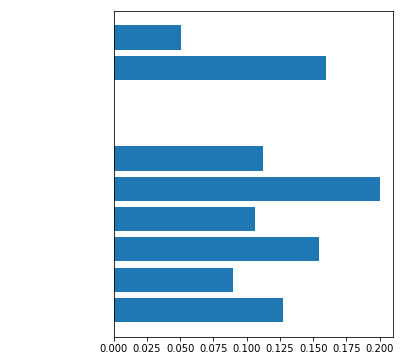

In [185]:
# Feature Importances
importances = gbm.feature_importances_
fig, ax = plt.subplots(figsize=(5, 6))
ax.barh(range(len(importances)), importances)
ax.tick_params(axis='y', colors='white', labelsize=10)
ax.set_yticklabels(gbm_model_fields)
plt.yticks(range(len(importances)), gbm_model_fields)
plt.show()

#### Tune GBM parameters

In [178]:
param_grid = {
        'n_estimators': [20,40,60],
        'max_depth': [3,4,6],
        'max_features': [3],
        'learning_rate': [0.10, 0.12, 0.14]
    }

gbm = GradientBoostingClassifier(random_state=0)

estimator = GridSearchCV(gbm,
                         param_grid, 
                         scoring='neg_log_loss',
                         n_jobs=-1)

In [179]:
# fit model
estimator.fit(model_train_df[gbm_model_fields], model_train_df['Result'])

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [20, 40, 60], 'max_depth': [3, 4, 6], 'max_features': [3], 'learning_rate': [0.1, 0.12, 0.14]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [180]:
preds = estimator.predict_proba(model_test_df[gbm_model_fields])[:, 1]
print(calc_logloss(preds, model_test_df['Result']))

0.5847661711058076


In [181]:
# Look at best parameter set
print(estimator.best_params_)
print(estimator.best_score_)

{'learning_rate': 0.1, 'max_depth': 4, 'max_features': 3, 'n_estimators': 60}
-0.5519292556034899


### Feature Selection

In [188]:
importances = feature_selection.f_classif(model_train_df[logistic_model_fields], model_train_df['Result'])

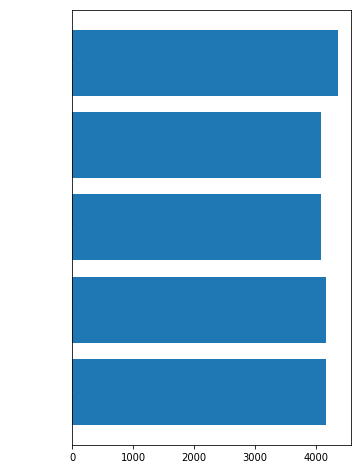

In [189]:
fig, ax = plt.subplots(figsize=(5, 8))
ax.barh(range(len(importances[0])), importances[0])
ax.tick_params(axis='y', colors='white', labelsize=10)
ax.set_yticklabels(logistic_model_fields)
plt.yticks(range(len(importances[0])), logistic_model_fields)
plt.show()

## Modeling - predict point spread
* Predict point spread directly -> convert to win probability
* Predict possessions, ppp -> convert to final score -> convert to win probability

In [186]:
gbm = GradientBoostingRegressor(n_estimators=40, 
                                max_depth=4, 
                                 max_features=3,
                                learning_rate=0.10)

In [187]:
gbm.fit(model_train_df[gbm_model_fields], model_train_df['score_diff'])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=3,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=40, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [188]:
# create preds
preds = gbm.predict(model_test_df[gbm_model_fields])
preds = np.array([scipy.stats.norm(0,10.5).cdf(pred) for pred in preds])

In [189]:
print(calc_logloss(preds, model_test_df['Result']))

0.5851967500305698


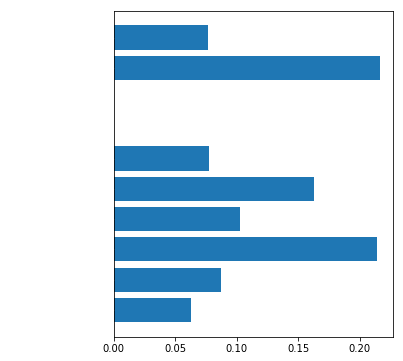

In [190]:
# Feature Importances
importances = gbm.feature_importances_
fig, ax = plt.subplots(figsize=(5, 6))
ax.barh(range(len(importances)), importances)
ax.tick_params(axis='y', colors='white', labelsize=10)
ax.set_yticklabels(gbm_model_fields)
plt.yticks(range(len(importances)), gbm_model_fields)
plt.show()

In [191]:
param_grid = {
        'n_estimators': [20,40],
        'max_depth': [4,5,6],
        'max_features': [3],
        'learning_rate': [0.08, 0.10, 0.15]
    }

gbm = GradientBoostingRegressor(random_state=0)

estimator = GridSearchCV(gbm,
                         param_grid, 
                         scoring='neg_mean_squared_error',
                         n_jobs=-1)

In [192]:
# fit model
estimator.fit(model_train_df[gbm_model_fields], model_train_df['score_diff'])

# Look at best parameter set
print(estimator.best_params_)
print(estimator.best_score_)

# create preds
preds = estimator.predict(model_test_df[gbm_model_fields])
preds = np.array([scipy.stats.norm(0,10.5).cdf(pred) for pred in preds])
print(calc_logloss(preds, model_test_df['Result']))

{'learning_rate': 0.1, 'max_depth': 4, 'max_features': 3, 'n_estimators': 40}
-114.81611485706023
0.584697777667191


## Create 2018 preds

##### Create test data set

In [43]:
test = sample_sub2.copy()

In [44]:
test['t1_TeamID'] = [int(x[5:9]) for x in test['ID']]
test['t2_TeamID'] = [int(x[10:14]) for x in test['ID']]
test['DayNum'] = 135
test['Season'] = 2018
print(test.shape)

In [48]:
for rnk_sys in massey_rank_systems:
    test = add_in_massey_ordinal_field(test, rnk_sys, massey_ordinals)

In [49]:
# Create location variables
test['t1_Loc_H'] = 0
test['t1_Loc_N'] = 1

##### Create test preds

In [55]:
test_preds = estimator.predict_proba(test[logistic_model_fields])[:, 1]
print(len(test_preds))

2278


In [56]:
test_preds[0:10]

array([0.36287436, 0.48639683, 0.39416024, 0.41164741, 0.67532664,
       0.60973142, 0.40566186, 0.32114067, 0.3826258 , 0.88632615])

##### Create submission file

In [57]:
submission_df = pd.DataFrame()
submission_df['ID'] = test['ID']
submission_df['Pred'] = test_preds
print(submission_df.shape)

(2278, 2)


In [58]:
submission_df.head()

,ID,Pred
0,2018_1104_1112,0.362874
1,2018_1104_1305,0.486397
2,2018_1104_1116,0.394160
3,2018_1104_1120,0.411647
4,2018_1104_1137,0.675327


### Check first round

In [133]:
first_round_games = read_in_file_to_df("first_round_games")

first_round_games (32, 5)


In [134]:
def calc_vegas_line_preds(row):
    if row['vegas_line'] >= 0:
        return abs(scipy.stats.norm(0,10.5).cdf(row['vegas_line']) - 1)
    else:
        return 1 - scipy.stats.norm(0,10.5).cdf(row['vegas_line'])

In [135]:
first_round_games['vegas_line_preds'] = first_round_games.apply(calc_vegas_line_preds, axis=1)

In [136]:
check_my_preds = pd.merge(left=first_round_games, right=submission_df, on='ID', how='left')

In [138]:
check_my_preds[['t1_name', 't2_name', 'pred_538', 'vegas_line_preds', 'Pred']].round(2)

,t1_name,t2_name,pred_538,vegas_line_preds,Pred
0,UMBC,Virginia,0.02,0.01,0.06
1,Creighton,Kansas State,0.58,0.56,0.61
2,Davidson,Kentucky,0.24,0.28,0.36
3,Ariziona,Buffalo,0.85,0.80,0.72
4,Loyola-Chicago,Miami,0.40,0.42,0.37
5,Tennessee,Wright St.,0.91,0.89,0.85
6,Nevada,Texas,0.40,0.54,0.50
7,Cincinnati,Georgia St.,0.93,0.91,0.89
8,NCCU,Xavier,0.02,NaN,0.06
9,FSU,Missouri,0.71,0.54,0.51


In [96]:
# Some reference sites:

# 538 preds:
#https://projects.fivethirtyeight.com/2018-march-madness-predictions/

# Vegas odds:
#http://www.vegasinsider.com/college-basketball/odds/las-vegas/

# ESPN schedule:
#http://www.espn.com/mens-college-basketball/scoreboard/_/date/20180315